Используя библиотеку Natasha извлечь все названия организаций и адреса из текстов новостей. Построить граф социальной сети для организаций, упоминавшихся в новостях, считая, что организация и адрес, встретившиеся в одной заметке связаны между собой.Найти наиболее вероятные адреса организаций.

Импортируем нужные модули

In [55]:
from bs4 import BeautifulSoup
import requests
import re
from natasha import Segmenter, MorphVocab, NewsEmbedding, NewsMorphTagger, NewsSyntaxParser, NewsNERTagger, PER, NamesExtractor, AddrExtractor, Doc

In [56]:
%matplotlib notebook
import matplotlib.pyplot as plt
import networkx as nx
import math
import numpy as np
from tqdm import tqdm

Делаем суп из html со ссылки на сайт

In [68]:
url = "http://izvestiaur.ru/news/?PAGEN_1="

def get_page(j):
    url = "http://izvestiaur.ru/news/?PAGEN_1="
    new_url = url + str(j)
    response = requests.get(new_url)
    soup = BeautifulSoup(response.text)
    
    return soup

Ищем ссылки на новости, приводим их к нужному виду.

In [69]:
def get_links(soup):
    a_elems = soup.find_all('a')

    links = []
    normal_links = []
    
    for elem in a_elems:
        match = re.search(r'/news/view/\d+', elem["href"])
        if match and elem["href"] not in links:
            links.append(elem["href"])
    for link in links:
        normal_link = re.search(r'http://www.izvestiaur.ru/news/view/\d+', link)
        if normal_link:
            normal_links.append(link)
        if not normal_link:
            link = 'http://www.izvestiaur.ru' + link
            normal_links.append(link)
        
    return normal_links


Функция, которая достает текст статьи по ссылке.

In [88]:
def get_article(some_url):
    response_news = requests.get(some_url)
    news_soup = BeautifulSoup(response_news.text)
    news_text = news_soup.find_all("div")
    some_article = [some_url + '\n', 'Известия Удмуртской Республики\n']
    title = news_soup.find_all("h1")


    for elem in news_text:
        if elem.get('class') != None:
            if elem['class'] == ['article-date']:
                for string in elem.stripped_strings:
                    some_article.append(string+'\n')
    for elem in title:
        if elem.attrs == {}:
            for string in elem.stripped_strings:
                some_article.append(string + '\n')
    for elem in news_text:
        if elem.get('class') != None:
            if elem['class'] == ['article-anonce']:
                for string in elem.stripped_strings:
                    some_article.append(string)
        if elem.get('style') != None:        
            if len(elem.attrs) == 1 and elem['style'] == 'margin-top:5px;':
                for string in elem.stripped_strings:
                    some_article.append(string)
    k = 0               
    for i in range(len(some_article)):
        if 'Автор:' in some_article[i]:
            some_article.insert(3, some_article[i+1] + '\n')
            k += 1
            some_article.pop(i+1)
            some_article.pop(i+1)
            break
    if k == 0:
        some_article.insert(2, 'Автор не указан\n')

    this_article = ' '.join(some_article)

    return this_article

Достаем все тексты.

In [89]:
stats = []
for i in tqdm(range(1, 5)):
    pages = get_page(i)
    urls = get_links(pages)
    for url in urls:
        stats.append(get_article(url))
        stats.append('\n=====\n')







  0%|                                                                                            | 0/4 [00:00<?, ?it/s]




 25%|█████████████████████                                                               | 1/4 [00:09<00:29,  9.94s/it]




 50%|██████████████████████████████████████████                                          | 2/4 [00:20<00:20, 10.04s/it]




 75%|███████████████████████████████████████████████████████████████                     | 3/4 [00:33<00:10, 10.91s/it]




100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:44<00:00, 11.25s/it]


Кладем тексты в файл.

In [103]:
with open('news_update.txt', "w", encoding = 'utf-8') as f:
    for s in stats:
        f.write(s)

Берем файл и читаем тексты.

In [104]:
with open('news_update.txt', encoding = 'utf-8') as f:
    text = f.read().split('\n=====\n')

Функции для работы с Natasha

In [105]:
segmenter = Segmenter()
morph_vocab = MorphVocab()

emb = NewsEmbedding()
morph_tagger = NewsMorphTagger(emb)
syntax_parser = NewsSyntaxParser(emb)
ner_tagger = NewsNERTagger(emb)

names_extractor = NamesExtractor(morph_vocab)
addr_extractor = AddrExtractor(morph_vocab)

Функция для поиска организаций в тексте

In [106]:
def name_search(some_text):
    doc = Doc(some_text)
    doc.segment(segmenter)
    doc.tag_morph(morph_tagger)
    doc.parse_syntax(syntax_parser)
    doc.tag_ner(ner_tagger)
    
    for token in doc.tokens:
        token.lemmatize(morph_vocab)
        
    for span in doc.spans:
        span.normalize(morph_vocab)
        
    org_and_adr = []
    org_and_adr = [(s.normal, s.type) for s in doc.spans if s.type == 'ORG' and (s.normal, s.type) not in org_and_adr]
    for s in doc.spans:
        if s.type == 'LOC' and (s.normal, s.type) not in org_and_adr:
            org_and_adr.append((s.normal, s.type))
    
    return org_and_adr

Функция для получения названий организаций и адресов, а также связей между ними

In [107]:
def getorgs(some_text):
    orgs = {}
    connect = {}
    
    for art in tqdm(some_text):
        snam = name_search(art)
        for n in snam:
            orgs[n] = orgs.get(n, 0)+1
            pers=connect.get(n, {})
            for n2 in snam:
                if n != n2 and n[1] != n2[1]:
                    pers[n2] = pers.get(n2, 0)+1
            connect[n] = pers
    
    return orgs, connect

In [108]:
organisations, connections = getorgs(text)






  0%|                                                                                          | 0/189 [00:00<?, ?it/s]




  1%|▍                                                                                 | 1/189 [00:00<00:31,  5.93it/s]




  2%|█▎                                                                                | 3/189 [00:00<00:27,  6.82it/s]




  2%|█▋                                                                                | 4/189 [00:00<00:27,  6.84it/s]




  3%|██▏                                                                               | 5/189 [00:00<00:24,  7.41it/s]




  3%|██▌                                                                               | 6/189 [00:00<00:26,  7.01it/s]




  4%|███▍                                                                              | 8/189 [00:00<00:21,  8.46it/s]




  5%|████▎                                                                            | 10/189 [00:01<00:18,  9.49it/s]




  6

 75%|████████████████████████████████████████████████████████████                    | 142/189 [00:10<00:03, 13.32it/s]




 76%|████████████████████████████████████████████████████████████▉                   | 144/189 [00:11<00:03, 13.33it/s]




 77%|█████████████████████████████████████████████████████████████▊                  | 146/189 [00:11<00:03, 14.01it/s]




 78%|██████████████████████████████████████████████████████████████▋                 | 148/189 [00:11<00:03, 13.51it/s]




 79%|███████████████████████████████████████████████████████████████▍                | 150/189 [00:11<00:02, 14.00it/s]




 80%|████████████████████████████████████████████████████████████████▎               | 152/189 [00:11<00:02, 14.85it/s]




 81%|█████████████████████████████████████████████████████████████████▏              | 154/189 [00:11<00:02, 15.58it/s]




 83%|██████████████████████████████████████████████████████████████████              | 156/189 [00:11<00:02, 15.79it/s]




 84%|███

Уменьшаем количество организаций и мест

In [109]:
org2={n:{n2:connections[n][n2] for n2 in connections[n].keys() if organisations[n2]>20 and n2!=')'}
           for n in connections.keys() if organisations[n]>20 and n!=')'}
org2

{('Известия Удмуртская Республика', 'LOC'): {('ВКонтакте', 'ORG'): 21,
  ('МВД', 'ORG'): 64,
  ('Городская дума', 'ORG'): 44,
  ('ОНФ', 'ORG'): 28},
 ('Ижевск', 'LOC'): {('МВД', 'ORG'): 28,
  ('ВКонтакте', 'ORG'): 13,
  ('Городская дума', 'ORG'): 44,
  ('ОНФ', 'ORG'): 28},
 ('Удмуртия', 'LOC'): {('ВКонтакте', 'ORG'): 21,
  ('МВД', 'ORG'): 56,
  ('Городская дума', 'ORG'): 20,
  ('ОНФ', 'ORG'): 28},
 ('ВКонтакте', 'ORG'): {('Известия Удмуртская Республика', 'LOC'): 21,
  ('Удмуртия', 'LOC'): 21,
  ('Ижевск', 'LOC'): 13,
  ('Воткинск', 'LOC'): 5},
 ('МВД', 'ORG'): {('Известия Удмуртская Республика', 'LOC'): 64,
  ('Удмуртская Республика', 'LOC'): 44,
  ('Ижевск', 'LOC'): 28,
  ('Удмуртия', 'LOC'): 56,
  ('Россия', 'LOC'): 12,
  ('Воткинск', 'LOC'): 16},
 ('Удмуртская Республика', 'LOC'): {('МВД', 'ORG'): 44, ('ОНФ', 'ORG'): 28},
 ('Воткинск', 'LOC'): {('ВКонтакте', 'ORG'): 5, ('МВД', 'ORG'): 16},
 ('Россия', 'LOC'): {('МВД', 'ORG'): 12, ('Городская дума', 'ORG'): 12},
 ('Городская дума', 

Функция построения графа

In [110]:
def form_a_graph(orgs_and_addrs):
    G=nx.Graph()
    for n in orgs_and_addrs.keys():
        for n2 in orgs_and_addrs[n].keys():
            G.add_edge(n, n2)
            
    return G

In [111]:
G1 = form_a_graph(org2)

In [112]:
def draw_a_graph(G, orgs_and_addrs, freqs, colors = 'b', layout = 'spring'):
    if layout=='kawai':
        pstn=nx.kamada_kawai_layout(G)
    elif layout=='circle':
        pstn=nx.drawing.layout.circular_layout(G2)
    elif layout=='random':
        pstn=nx.drawing.layout.random_layout(G2)
    else:
        pstn=nx.spring_layout(G)
        
    sz=[freqs[n] for n in G.nodes]  
    
    lw=[math.log(orgs_and_addrs[e[0]][e[1]], 10)+1 for e in G.edges]
    
    nx.draw(G, pos=pstn, node_color=colors, edge_color='g', with_labels=True, node_size=sz, width=lw);

<IPython.core.display.Javascript object>


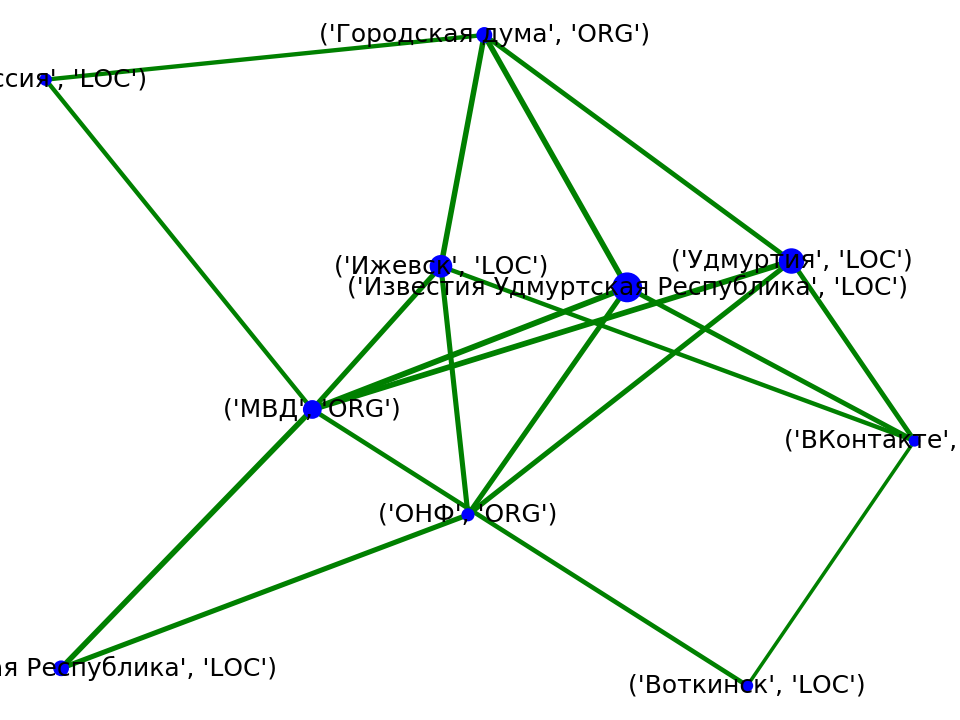

In [113]:
draw_a_graph(G1, org2, organisations)